In [74]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image
from concurrent.futures import ProcessPoolExecutor
from scipy.ndimage import binary_dilation

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = (1024, 768)  # the generated image resolution
    train_batch_size = 4
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-6
    lr_warmup_steps = 10
    save_image_epochs = 5
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "baseline"  # the model name locally and on the HF Hub
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    num_steps=2000
    num_samples=11647
    seed = 0


config = TrainingConfig()

In [3]:
annotations_file=os.path.join(".", 'VITONHD_train_paired.txt')
with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()][:config.num_samples]

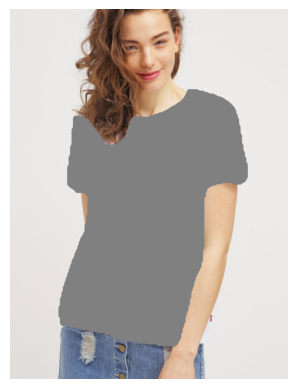

In [98]:
### DATASET_DIR = "../datasets/viton-hd"
img_dir = os.path.join(DATASET_DIR, 'train')
output_dir = os.path.join(".", "mask_train_dataset")

# Số pixel để mở rộng viền vùng mask
padding = 20  # Số pixel mở rộng

person_path, clothing_path = image_pairs[0]

image = Image.open(f"{img_dir}/image/{person_path}").convert("RGB")

image_parse_v3 = Image.open(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}").convert("RGB")

image_parse_v3_binary = np.where(np.all((np.array(image_parse_v3) == [254, 85, 0]) | (np.array(image_parse_v3) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8") == 1
if image_parse_v3_binary.sum() == 0:
    image_parse_v3_binary = np.where(np.all(np.array(image_parse_v3) == [0, 0, 85], axis=-1), 1, 0).astype("uint8") == 1
    
image_parse_v3_binary = binary_dilation(image_parse_v3_binary, structure=np.ones((padding, padding)))

# image_parse_v3 = np.array(image_parse_v3)
# image_parse_v3[image_parse_v3_binary] = [254, 85, 0]

# image_parse_v3 = Image.fromarray(image_parse_v3).convert("RGB")

image = np.array(image)
image[image_parse_v3_binary] = [128, 128, 128]

image = Image.fromarray(image).convert("RGB")

plt.imshow(image)
plt.axis('off')
plt.show()

In [100]:
DATASET_DIR = "../datasets/viton-hd"
img_dir = os.path.join(DATASET_DIR, 'train')
output_dir = os.path.join(".", "mask_train_dataset")

# Số pixel để mở rộng viền vùng mask
padding = 20  # Số pixel mở rộng

def preprocess(image_pair):
    person_path, clothing_path = image_pair
    agnostic_mask = Image.open(f"{img_dir}/agnostic-v3.2/{person_path}").convert("RGB")
    
    image_parse_v3 = Image.open(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}").convert("RGB")
    image_parse_v3_binary = np.where(np.all((np.array(image_parse_v3) == [254, 85, 0]) | (np.array(image_parse_v3) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8")
    if image_parse_v3_binary.sum() == 0:
        print(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}")
        image_parse_v3_binary = np.where(np.all(np.array(image_parse_v3) == [0, 0, 85], axis=-1), 1, 0).astype("uint8")
    
    image_parse_v3_binary = binary_dilation(image_parse_v3_binary, structure=np.ones((padding, padding)))
    matplotlib.image.imsave(os.path.join(output_dir, "image_parse_v3_binary2", person_path), image_parse_v3_binary, cmap='gray')

# for idx in tqdm(range(len(image_pairs))):
#     person_path, clothing_path = image_pairs[idx]
    
#     # agnostic_mask = Image.open(f"{img_dir}/agnostic-v3.2/{person_path}").convert("RGB")
#     # agnostic_mask_binary = np.where(np.all(np.array(agnostic_mask) == [128, 128, 128], axis=-1), 1, 0).astype("uint8")
#     # matplotlib.image.imsave(os.path.join(output_dir, "agnostic_mask_binary", person_path), agnostic_mask_binary, cmap='gray')
    
#     image_parse_v3 = Image.open(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}").convert("RGB")
#     image_parse_v3_binary = np.where(np.all((np.array(image_parse_v3) == [254, 85, 0]) | (np.array(image_parse_v3) == [0, 119, 220]), axis=-1), 1, 0).astype("uint8")
#     if image_parse_v3_binary.sum() == 0:
#         print(f"{img_dir}/image-parse-v3/{person_path.replace('jpg', 'png')}")
#         image_parse_v3_binary = np.where(np.all(np.array(image_parse_v3) == [0, 0, 85], axis=-1), 1, 0).astype("uint8")
    
#     image_parse_v3_binary = binary_dilation(image_parse_v3_binary, structure=np.ones((padding, padding)))
#     matplotlib.image.imsave(os.path.join(output_dir, "image_parse_v3_binary", person_path), image_parse_v3_binary, cmap='gray')

with ProcessPoolExecutor(max_workers=4) as executor:
    p = executor.map(preprocess, image_pairs)

../datasets/viton-hd/train/image-parse-v3/00026_00.png
../datasets/viton-hd/train/image-parse-v3/00122_00.png
../datasets/viton-hd/train/image-parse-v3/00234_00.png
../datasets/viton-hd/train/image-parse-v3/00266_00.png
../datasets/viton-hd/train/image-parse-v3/00362_00.png
../datasets/viton-hd/train/image-parse-v3/00643_00.png
../datasets/viton-hd/train/image-parse-v3/00730_00.png
../datasets/viton-hd/train/image-parse-v3/00804_00.png
../datasets/viton-hd/train/image-parse-v3/00917_00.png
../datasets/viton-hd/train/image-parse-v3/00956_00.png
../datasets/viton-hd/train/image-parse-v3/01021_00.png
../datasets/viton-hd/train/image-parse-v3/01119_00.png
../datasets/viton-hd/train/image-parse-v3/01122_00.png
../datasets/viton-hd/train/image-parse-v3/01185_00.png
../datasets/viton-hd/train/image-parse-v3/01330_00.png
../datasets/viton-hd/train/image-parse-v3/01331_00.png
../datasets/viton-hd/train/image-parse-v3/01391_00.png
../datasets/viton-hd/train/image-parse-v3/01539_00.png
../dataset